# ADA final exam (Fall 2023)

This exam consists of 2 parts. Parts are independent from each other.

## Dataset


"Friends" is an American television sitcom that originally aired on NBC from September 22, 1994, to May 6, 2004. Created by David Crane and Marta Kauffman, the show gained immense popularity and has since become a classic in the world of television. The series is set in New York City and revolves around a group of six friends: Ross Geller (David Schwimmer), Rachel Green (Jennifer Aniston), Monica Geller (Courteney Cox), Chandler Bing (Matthew Perry), Joey Tribbiani (Matt LeBlanc), and Phoebe Buffay (Lisa Kudrow). The show explores their personal and professional lives as they navigate the ups and downs of relationships, careers, and the challenges of adulthood.

In this exam, we will use a dataset containing all the conversations that occurred over 10 seasons of Friends. We refer to each row in the dataset as an 'utterance." The data format of the dataset is as follows

- id: `<str>`, the index of the utterance in the format sAA_eBB_cCC_uDDD, where AA is the season number, BB is the episode number, CC is the scene/conversation number, and DDD is the number of the utterance in the scene (e.g. s01_e18_c05_u021).
- speaker: `<str>`, the speaker who made the utterance, e.g. Monica Geller
- conversation_id: `<str>`, the id of the first utterance in the conversation this utterance belongs. We assume conversations begin at the start of a new scene.
- reply_to: `<str>`, the id of the utterance to which this utterance replies. None if the utterance is the first in a conversation.
- text: `<str>`, the textual content of the utterance.


In [1]:
# First, let's import some required libraries!
import statsmodels.formula.api as smf
import pandas as pd
from collections import Counter
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np


## Part 1: The one where you find the protagonist (60 pts)

A big debate among Friends fans is: who is the show's main character? In this task, your goal is to provide a data-driven answer to this question.


--- 

**1.1 —** Load the data from the jsonl file `exam1.jsonl` into a pandas dataframe. Then
 
 A. Calculate and display the number of distinct speakers in the dataframe.
 
 B. Calculate and display the number of conversations (see `conversation_id`).
 
 C. Remove all utterances from the dataframe where the `speaker` is "TRANSCRIPT_NOTE" or "#ALL#". Print the number of rows in the dataframe.
 
 D. Create additional columns corresponding to the season (`season`, e.g., season 1 should contain `s01`) and the episode (`episode`, e.g., episode 5 of season 4 should contain `s04_e05`) of each utterance. Print the season and the episode associated with utterance `s10_e18_c11_u019`.
 
 E. Create an additional column corresponding to the length of each utterance in terms of the number of characters (`length`). Print the length associated with utterance `s10_e18_c11_u019`.


In [8]:
# Load the data
exam1_df = pd.read_json("data/exam1.jsonl", lines=True)
exam1_df.head()

,id,conversation_id,text,speaker,reply-to
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002
3,s01_e01_c01_u004,s01_e01_c01_u001,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003
4,s01_e01_c01_u005,s01_e01_c01_u001,,TRANSCRIPT_NOTE,s01_e01_c01_u004


In [30]:
# A Calculate and display the number of distinct speakers in the dataframe
# display(exam1_df['speaker'].unique())

# Drop TRANSCRIPT_NOTE and #ALL#
distinct_speakers = exam1_df[exam1_df['speaker']!='TRANSCRIPT_NOTE']
distinct_speakers = distinct_speakers[distinct_speakers['speaker']!='#ALL#']
distinct_num = distinct_speakers['speaker'].nunique()
print(distinct_num, " distinct speakers")

698  distinct speakers


In [32]:
# B Calculate and display the number of conversations 
distinct_conv = exam1_df['conversation_id'].nunique()
print(distinct_conv, " distinct conversations")

3107  distinct conversations


In [33]:
# C Remove all utterances from the dataframe where the `speaker` is "TRANSCRIPT_NOTE" or "#ALL#". 
# Print the number of rows in the dataframe.

exam1_df = exam1_df[exam1_df['speaker']!='TRANSCRIPT_NOTE']
exam1_df = exam1_df[exam1_df['speaker']!='#ALL#']
print(exam1_df.shape[0], ' rows in the dataframe')

60985  rows in the dataframe


In [45]:
# D Create additional columns corresponding to the season (`season`, e.g., season 1 should contain `s01`) 
# and the episode (`episode`, e.g., episode 5 of season 4 should contain `s04_e05`) of each utterance. 
# Print the season and the episode associated with utterance `s10_e18_c11_u019`.

def find_season(conversation_id):
    season = conversation_id[:3]
    return season

def find_episode(conversation_id):
    episode = conversation_id[:7]
    return episode

exam1_df['season'] = exam1_df['conversation_id'].apply(lambda x: find_season(x))
exam1_df['episode'] = exam1_df['conversation_id'].apply(lambda x: find_episode(x))
display(exam1_df)

print("s10_e18_c11_u019: ", exam1_df.set_index("id").loc["s10_e18_c11_u019", ["season", "episode"]].values)

,id,conversation_id,text,speaker,reply-to,season,episode
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None,s01,s01_e01
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001,s01,s01_e01
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,s01,s01_e01
3,s01_e01_c01_u004,s01_e01_c01_u001,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003,s01,s01_e01
5,s01_e01_c01_u006,s01_e01_c01_u001,"Just, 'cause, I don't want her to go through w...",Phoebe Buffay,s01_e01_c01_u005,s01,s01_e01
...,...,...,...,...,...,...,...
67368,s10_e18_c11_u017,s10_e18_c11_u000,"Oh, it's gonna be okay.",Chandler Bing,s10_e18_c11_u016,s10,s10_e18
67369,s10_e18_c11_u018,s10_e18_c11_u000,Do you guys have to go to the new house right ...,Rachel Green,s10_e18_c11_u017,s10,s10_e18
67370,s10_e18_c11_u019,s10_e18_c11_u000,We got some time.,Monica Geller,s10_e18_c11_u018,s10,s10_e18
67371,s10_e18_c11_u020,s10_e18_c11_u000,"Okay, should we get some coffee?",Rachel Green,s10_e18_c11_u019,s10,s10_e18


s10_e18_c11_u019:  ['s10' 's10_e18']


In [51]:
# E Create an additional column corresponding to the length of each utterance in terms of the number of characters (`length`). 
# Print the length associated with utterance `s10_e18_c11_u019`.

exam1_df['length'] = exam1_df['text'].apply(lambda x: len(x))

print("Length of text s10_e18_c11_u019: ", exam1_df.set_index("id").loc["s10_e18_c11_u019", ['length']].values)

Length of text s10_e18_c11_u019:  [17]


**1.2** Next, you conduct some basic analyses:

 A. With `statsmodels`, fit a linear regression `length ~ C(season, Treatment(reference="s01"))`, where length is an integer and season is a categorical variable. Print the regression summary.
 
 B. /**Discuss:/** Considering the regression summary:
   - What does the intercept in this regression represent? 
   - What does the coefficient `C(season, Treatment(reference="s01"))[T.s09]` represent? 
   - Does the average utterance in season 9 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary **only**. 
   - Does the average utterance in season 10 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary  **only** .

 C. Argue visually (i.e., with a plot) that there are 6 main characters in the show.

In [55]:
# A Fit a linear regression 
display(smf.ols("""length ~ C(season, Treatment(reference="s01"))""", data=exam1_df).fit().summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 length   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.058
Date:                Fri, 10 Jan 2025   Prob (F-statistic):           4.96e-12
Time:                        19:57:18   Log-Likelihood:            -3.2981e+05
No. Observations:               60985   AIC:                         6.596e+05
Df Residuals:                   60975   BIC:                         6.597e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       51.0190      0.704     72.464      0.000      49.639      52.399
C(season, Treatment(reference="s01"))[T.s02]     2.2764      1.004      2.268      0.023       0.309       4.243
C(season, Treatment(reference="s01"))[T.s03]     1.1906      0.974      1.222      0.222      -0.718       3.100
C(season, Treatment(reference="s01"))[T.s04]     0.6674      0.980      0.681      0.496      -1.253       2.588
C(season, Treatment(reference="s01"))[T.s05]    -0.3185      0.984     -0.324      0.746      -2.247       1.610
C(season, Treatment(reference="s01"))[T.s06]     1.9612      0.974      2.013      0.044       0.052       3.871
C(season, Treatment(reference="s01"))[T.s07]     0.3712      0.979      0.379      0.705      -1.548       2.290
C(season, Treatment(reference="s01"))[T.s08]     1.1265      0.982      1.147      0.251      -0.799       3.052
C(season, Treatment(reference="s01"))[T.s09]     6.0889      0.979      6.222      0.000       4.171       8.007
C(season, Treatment(reference="s01"))[T.s10]    -0.8470      1.026     -0.825      0.409      -2.858       1.164
==============================================================================
Omnibus:                    39360.499   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           721113.209
Skew:                           2.832   Prob(JB):                         0.00
Kurtosis:                      18.865   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

B) 
- The intercept is the predicted value when every other coefficient is equal to zero. Here it represents the average utterance length in season 1.
- This coefficient represents the additional length of the average utterance in season 9 compared to the average utterance length in season 1.
- Yes because the p value assigned to the season 9 coeffiient is smaller than 0.05
- No because the p value assigned to the season 10 coefficient is bigger than 0.05

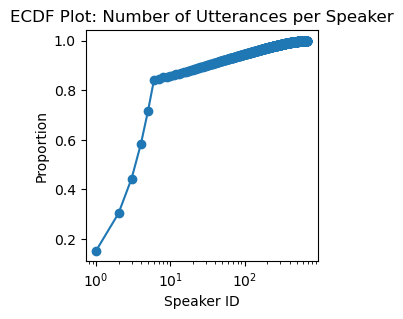

In [56]:
# C Argue visually that there are 6 main characters in the show
# calculates ecdf
tmp = exam1_df.groupby("speaker").count().conversation_id.sort_values(ascending=False).reset_index().conversation_id
tmp = tmp.cumsum()
tmp = tmp/tmp.values[-1]


# simple plot
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
plt.plot(tmp.index + 1, tmp)
plt.scatter(tmp.index + 1, tmp)
plt.xscale("log")
plt.ylabel("Proportion")
plt.xlabel("Speaker ID")
plt.title("ECDF Plot: Number of Utterances per Speaker");

--- 
**1.3 —** Using `networkx` 

A. Create a `MultiDiGraph` (directed graph with self loops and parallel edges) where:
- Each node $u$ is a character uniquely identified by the `speaker` field.
- There is an edge between nodes $u$ and $v$ if $u$ replied to $v$. If an utterance (a row in the dataframe) is said in reply to nobody, then it will not correspond to an edge. Each edge should contain two attributes. Each edge should have two attributes: `season` and `episode`.

B. Print the number of nodes and edges in your graph.

C. **/Discuss:/** Instead of using multi-edges, what would be another way in which you could capture the number of replies associated with each node pair?


In [58]:
import networkx as nx

In [67]:
# A  Create a `MultiDiGraph` (directed graph with self loops and parallel edges) where:
# - Each node $u$ is a character uniquely identified by the `speaker` field.
# - There is an edge between nodes $u$ and $v$ if $u$ replied to $v$. If an utterance (a row in the dataframe) is said in reply to nobody,
#   then it will not correspond to an edge. Each edge should contain two attributes. Each edge should have two attributes: 
#   `season` and `episode`.

df = exam1_df.merge(exam1_df[["id", "speaker"]], right_on="id", left_on="reply-to", how="left")

df["season"] = df["conversation_id"].apply(lambda x: x.split("_")[0])
df["episode"] = df["conversation_id"].apply(lambda x: "_".join(x.split("_")[:2]))

display(df.head())

# Get only rows with replies
df_only_replies = df[~df.speaker_y.isna()]

# creates graph
G = nx.from_pandas_edgelist(df_only_replies, 'speaker_x', 'speaker_y', 
                            edge_attr=["season", "episode"],
                            create_using=nx.MultiDiGraph())

,id_x,conversation_id,text,speaker_x,reply-to,season,episode,length,id_y,speaker_y
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None,s01,s01_e01,56,NaN,NaN
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001,s01,s01_e01,80,s01_e01_c01_u001,Monica Geller
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,s01,s01_e01,72,s01_e01_c01_u002,Joey Tribbiani
3,s01_e01_c01_u004,s01_e01_c01_u001,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003,s01,s01_e01,24,s01_e01_c01_u003,Chandler Bing
4,s01_e01_c01_u006,s01_e01_c01_u001,"Just, 'cause, I don't want her to go through w...",Phoebe Buffay,s01_e01_c01_u005,s01,s01_e01,79,NaN,NaN


In [64]:
# B Print the number of nodes and edges
print("Number of nodes :", len(G.nodes), "\nNumber of edges :", len(G.edges))

Number of nodes : 692 
Number of edges : 54904


C) We could use weighted edges instead of multi-edges.

---
With the graph ready, you set out to investigate who is the true protagonist of Friends.

Ignore the graph you generated previously and instead use the graph provided in `exam2.graphml`. Note that this graph may be slightly different from what you generated, but treat it as the ground truth. We provide you with code to load the graph below.


In [68]:
import networkx as nx

G = nx.read_graphml("./data/exam2.graphml")

---

**1.4 —** Using the provided MultiDiGraph $G$:

A. Calculate the out-degree of each node (also known as out-degree centrality). Please do not use the `nx.out_degree_centrality` function here, as it normalizes the degree. (E.g., if a node has 5 outgoing edges, it should have out-degree 5 according to your code.)

B. Calculate the PageRank centrality of each node in $G$. Use the default parameters.

C. Print both centrality metrics calculated above for the six main characters of Friends.

D. **/Discuss:/** According to the metrics, who is the most important character in Friends?

In [78]:
# A Calculate the out-degree of each node
og  = {n: d for n, d in G.out_degree()}
og = pd.DataFrame({(x,y) for x, y in  og.items()}, columns=["speaker", "outdegree"]).sort_values(by="outdegree", ascending=False)
og.head()

,speaker,outdegree
678,Rachel Green,8470
314,Ross Geller,8234
613,Chandler Bing,7702
348,Monica Geller,7621
686,Joey Tribbiani,7395


In [84]:
# B Calculate the PageRamk centrality of each node in G
pr = nx.pagerank(G)
pr = pd.DataFrame({(x,y) for x, y in pr.items()}, columns=['speaker', 'pagerank']).sort_values(by='pagerank', ascending=False)
pr.head()

,speaker,pagerank
584,Rachel Green,0.126843
264,Ross Geller,0.125611
568,Chandler Bing,0.114535
119,Monica Geller,0.113450
626,Joey Tribbiani,0.112835


In [85]:
centrality_df = pr.merge(og, on='speaker', how='inner')
display(centrality_df.head(6))

,speaker,pagerank,outdegree
0,Rachel Green,0.126843,8470
1,Ross Geller,0.125611,8234
2,Chandler Bing,0.114535,7702
3,Monica Geller,0.113450,7621
4,Joey Tribbiani,0.112835,7395
5,Phoebe Buffay,0.102069,6797


---

**1.5 —** **/True or false:/** Considering your answer in **1.4**, are the following statements true or false? Justify your answers. 

A. "If we inverted all  edges in the graph such that an edge $(u,v)$ becomes an edge $(v,u)$, the PageRank centrality would remain unchanged."

B. "If we removed all outgoing edges from Rachel Green, her PageRank centrality would remain unchanged."

C. "If a new node was introduced in the graph, with 1,000 outgoing edges towards each other node, but no incoming edge, it would have the highest PageRank centrality."


In [ ]:
# A) If we inverted all edges in the graph, then the out-degree of each node would change and thus the PageRank
#    centrality would also change, so it is False.

# B) False

# C) False

---

**1.6 —** Next, you consider how these centrality metrics vary over the course of the seasons.

A. Calculate the PageRank and out-degree centrality of the 6 main characters per episode, i.e., for each episode, create a graph containing only the utterances of that episode and calculate the PageRank centrality for this new graph. Print the PageRank and the out-degree of Rachel Green for the first episode of the first season.

B. Considering the episode-level out-degree centrality of Phoebe Buffay in season 1 and in season 10, print the mean and the standard error of the mean.

C. Create a single plot with 10 inches of width and 4 inches of height. The plot should contain two panels, containing the average PageRank centrality per season of Rachel Green and Ross Geller (Panel A), and the average out-degree per season of Rachel Green and Ross Geller (Panel B). Show 95% confidence intervals in your plot (calculated over the episodes in each season).

D. **/Discuss:/** Does the plot support the hypothesis that Rachel was the show's protagonist in all 10 seasons? Explain why.

In [87]:
# A Calculate the PageRank and out-degree centrality of the 6 main characters per episode

edge_episode = nx.get_edge_attributes(G, "episode")
episode_list = sorted(list(set(exam1_df.episode.values)))
speakers = set(list(df["speaker_x"]) + list(df["speaker_y"]))

subgraphs_pr = []
for episode in episode_list:
    relevant_edges = [k for k, v in edge_episode.items() if v == episode]
    subgraph = G.edge_subgraph(relevant_edges)
    pgr = list(nx.pagerank(subgraph).items())
    ogr  = {n: d for n, d in subgraph.out_degree()}
    other_chars = speakers - set(list(nx.pagerank(subgraph).keys()))
    
    for k, v in pgr:
        subgraphs_pr.append({"speaker": k, "pagerank": v, "outdegree": ogr[k], "episode": episode})
    
    for k in other_chars:
        subgraphs_pr.append({"speaker": k, "pagerank": 0, "outdegree": 0, "episode": episode})

df_pr_ep = pd.DataFrame(subgraphs_pr)
df_pr_ep["season"] = df_pr_ep["episode"].apply(lambda x: int(x[1:3]))
display(df_pr_ep[(df_pr_ep.speaker == "Rachel Green") & 
                 (df_pr_ep.episode == "s01_e01")].iloc[0])

speaker      Rachel Green
pagerank         0.153122
outdegree              43
episode           s01_e01
season                  1
Name: 0, dtype: object

In [100]:
# B. Considering the episode-level out-degree centrality of Phoebe Buffay in season 1 and in season 10, print the mean and the standard error of the mean.

df_pr_ep_phoebe = df_pr_ep[df_pr_ep['speaker']=='Phoebe Buffay']

print('Phoebe Buffay outegdree:')
display( df_pr_ep_phoebe.groupby('season').outdegree.agg(['mean', 'std']).loc[[1,10]])
print('Phoebe Buffay PageRank:')
display( df_pr_ep_phoebe.groupby('season').pagerank.agg(['mean', 'std']).loc[[1,10]])


Phoebe Buffay outegdree:


,mean,std
season,,
1,23.333333,10.781089
10,36.944444,11.918706


Phoebe Buffay PageRank:


,mean,std
season,,
1,0.104929,0.044012
10,0.130547,0.029894


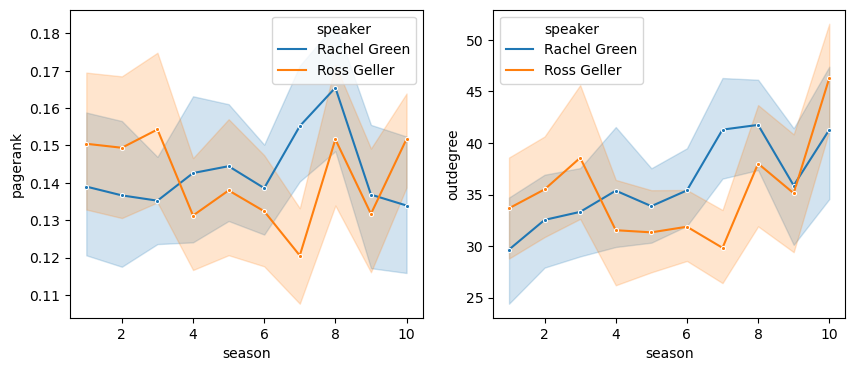

In [112]:
# C. Create a single plot with 10 inches of width and 4 inches of height. The plot should contain two panels, 
# containing the average PageRank centrality per season of Rachel Green and Ross Geller (Panel A), 
# and the average out-degree per season of Rachel Green and Ross Geller (Panel B). 
# Show 95% confidence intervals in your plot (calculated over the episodes in each season).

df_pr_ep = df_pr_ep[df_pr_ep['speaker'].isin(['Rachel Green', 'Ross Geller'])]

# df_pr_ep_rachel = df_pr_ep[df_pr_ep['speaker']=='Rachel Green']
# y_od_rachel = df_pr_ep_rachel.groupby('season').outdegree.agg(['mean', 'std'])
# y_pr_rachel = df_pr_ep_rachel.groupby('season').pagerank.agg(['mean', 'std'])

# df_pr_ep_ross = df_pr_ep[df_pr_ep['speaker']=='Ross Geller']
# y_od_ross = df_pr_ep_ross.groupby('season').outdegree.agg(['mean', 'std'])
# y_pr_ross = df_pr_ep_ross.groupby('season').pagerank.agg(['mean', 'std'])

fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey="col", sharex=True)
axs = axs.T.flatten()
        
sns.lineplot(x="season", y="pagerank", hue="speaker", data=df_pr_ep, 
             ax=axs[0],
            marker=".", )
sns.lineplot(x="season", y="outdegree", hue="speaker",  data=df_pr_ep, 
             ax=axs[1],
            marker=".");

In [114]:
# D. **/Discuss:/** Does the plot support the hypothesis that Rachel was the show's protagonist in all 10 seasons? Explain why.

# The plot does not the hypothesis that Rachel was the show's protagonist as Ross has higher pagerank and outdegree centrality in
# multiple seasons.

---

**1.7 —** **/True or false:/** Considering your answer in **1.6** are the following statements true or false? Justify your answer. 


A. "In season 7, Rachel Green's episode-level PageRank and out-degree centrality are higher than Ross Geller's. This difference is statistically significant at the 0.05 significance level."

B. "Phoebe Buffay's out-degree grew between season 1 and season 10; this implies that other characters spoke less than her in season 10."

C. "Phoebe Buffay's PageRank was higher in season 10 than in season 1. This difference is statistically significant at the 0.05 significance level and suggests that the character gained importance over the course of the show."


In [115]:
# A. True, the hues do not intersect each other
# B. False, this implies that she spoke to more characters in season 10
# C. True, 0.05 significance level means +-1.96 sem 

## Part 2: The one about text similarity (40 pts)

Next, you investigate how unique characters are by analyzing what they said throughout the 10 seasons.

**2.1 —** Load the dataframe `exam3.jsonl`. This dataframe is similar to `exam1.jsonl`, except:

- It has an additional column called `tokens`, containing a sentence list. Each sentence is another list composed of tokens, e.g.,
`[['There', "'s", 'nothing', 'to', 'tell', '!'], ['He', "'s", 'just', 'some', 'guy', 'I', 'work', 'with', '!']]`.
- It has an additional column called `episode` containing a unique episode identifier.
- It only contains utterances by Phoebe, Rachel, Ross, Joey, Monica, or Chandler (the main characters).
 
Given this dataframe, you will create an episode-level word-frequency matrix for Chandler Bing, one of the main characters.

A. Create a list $L$ containing all distinct tokens uttered by Chandler Bing throughout the 10 seasons, sorted in ascending order. Print the 10 first and last elements of the list. 

B. Create a matrix $X$ with $m$ rows and $n$ columns, where: $n$ is the number of tokens in the list $L$ that you just created, and $m$ is the number of episodes (236). Each position $X_{i,j}$ in this matrix should contain the number of times the character uttered the word $j$ in episode $i$. Print how many times Chandler uttered the token `joey` in the first episode of the first season, as well as the shape of the matrix $X$.

C. Transform the matrix $X$ into a TF-IDF matrix $T$, combining the following formula (as seen in class):

$$\text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th episode}$$

$$\text{IDF}(j) =  \log \frac{\text{number of episodes}}{\text{number of episodes in which the $j$-th word occurs}}$$

Print the value in the TF-IDF matrix corresponding to Chandler's utterance of the token `joey` in the first episode of the first season.

D. **/Discuss:/** Some of the tokens (e.g., `joey`) reference other characters. How may these tokens help a classifier predict which character uttered a sentence?

In [119]:
import networkx as nx
# Load the data
exam3_df = pd.read_json("data/exam3.jsonl", lines=True)
exam3_df.head()

,id,conversation_id,text,speaker,reply-to,tokens,episode
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None,"[[there, 's, nothing, to, tell, !], [he, 's, j...",s01_e01
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001,"[[c'mon, ,, you, 're, going, out, with, the, g...",s01_e01
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,"[[all, right, joey, ,, be, nice, .], [so, does...",s01_e01
3,s01_e01_c01_u004,s01_e01_c01_u001,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003,"[[wait, ,, does, he, eat, chalk, ?]]",s01_e01
4,s01_e01_c01_u006,s01_e01_c01_u001,"Just, 'cause, I don't want her to go through w...",Phoebe Buffay,s01_e01_c01_u005,"[[just, ,, ', cause, ,, i, do, n't, want, her,...",s01_e01


In [129]:
# A Create a list L of all distinct tokens uttered by Chandler Bing, sorted in ascending order, display the first 10 tokens

df_chandler_tokens = exam3_df[exam3_df['speaker']=='Chandler Bing']
df_chandler_tokens['tokens_flat'] = df_chandler_tokens['tokens'].apply(lambda xss: [x for xs in xss for x in xs])
display(df_chandler_tokens.head())

# Creates token index
token_index = [x for xs in df_chandler_tokens["tokens_flat"] for x in xs]
token_index = sorted(list(set(token_index)))

print("First 10 tokens", token_index[:10])
print(" Last 10 tokens", token_index[-10:])

C:\Users\jacqu\AppData\Local\Temp/ipykernel_1964/477627118.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chandler_tokens['tokens_flat'] = df_chandler_tokens['tokens'].apply(lambda xss: [x for xs in xss for x in xs])


,id,conversation_id,text,speaker,reply-to,tokens,episode,tokens_flat
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,"[[all, right, joey, ,, be, nice, .], [so, does...",s01_e01,"[all, right, joey, ,, be, nice, ., so, does, h..."
6,s01_e01_c01_u008,s01_e01_c01_u001,Sounds like a date to me.,Chandler Bing,s01_e01_c01_u007,"[[sounds, like, a, date, to, me, .]]",s01_e01,"[sounds, like, a, date, to, me, .]"
7,s01_e01_c01_u010,s01_e01_c01_u001,"Alright, so I'm back in high school, I'm stand...",Chandler Bing,s01_e01_c01_u009,"[[alright, ,, so, i, 'm, back, in, high, schoo...",s01_e01,"[alright, ,, so, i, 'm, back, in, high, school..."
8,s01_e01_c01_u012,s01_e01_c01_u001,"Then I look down, and I realize there's a phon...",Chandler Bing,s01_e01_c01_u011,"[[then, i, look, down, ,, and, i, realize, the...",s01_e01,"[then, i, look, down, ,, and, i, realize, ther..."
10,s01_e01_c01_u014,s01_e01_c01_u001,That's right.,Chandler Bing,s01_e01_c01_u013,"[[that, 's, right, .]]",s01_e01,"[that, 's, right, .]"


First 10 tokens ['!', '!!', '!!!', '!!!!', '!!!!!', '!!!!!!!', '!..', '!...', '!?', '"']
 Last 10 tokens ['yummy', 'yup', 'zack', 'zero', 'zip', 'zone', 'zoo', 'zorps', '{', '}']


In [130]:
# B. Create a matrix $X$ with $m$ rows and $n$ columns, where: $n$ is the number of tokens in the list $L$ that you just created, 
# and $m$ is the number of episodes (236). Each position $X_{i,j}$ in this matrix should contain the number of times the 
# character uttered the word $j$ in episode $i$. Print how many times Chandler uttered the token `joey` in the first episode 
# of the first season, as well as the shape of the matrix $X$.

# Creates episode index
episode_index = [x for x in  df_chandler_tokens["episode"]]
episode_index = sorted(list(set(episode_index)))

# Creates matrix
m, n = len(token_index), len(episode_index)
X = np.zeros((m,n))

# Populates matrix
for tokens, episode in zip(df_chandler_tokens["tokens_flat"].values, df_chandler_tokens["episode"].values):
    for token in tokens:
        X[token_index.index(token), episode_index.index(episode)] += 1

print(" How many times Chandler uttered the token joey in the first episode of the first season?",
      X[token_index.index("joey"), episode_index.index("s01_e01")])

print("X shape", X.shape)

 How many times Chandler uttered the token joey in the first episode of the first season? 1.0
X shape (6063, 236)


In [136]:
# C.

# X is the TF matrix
TF = X

# IDF
IDF = np.log(X.shape[1]/np.count_nonzero(X, axis=1))
# TF-IDF
TF_IDF = TF * IDF[:,None]

print("joey on TF-IDF", TF_IDF[token_index.index("joey"), episode_index.index("s01_e01")])

joey on TF-IDF 0.6931471805599453


In [137]:
# D. **/Discuss:/** Some of the tokens (e.g., `joey`) reference other characters. 
# How may these tokens help a classifier predict which character uttered a sentence?

# > Characters are unlikely to refer to their own names, so they can rule out a specific character.
# > Some characters may say other specific character name more frenquently, so this can help determine who is who.

---
For the remainder of the task, you will use the TF-IDF matrix that we compute below. Note:
- This matrix was calculated in a slightly different way: it considers only the 1000 tokens with the highest term frequency.
- We provide three useful variables below (`X`, `y`, and `df_tfidf`). 
    - `X` is a matrix containing the TF-IDF values for the top 1000 tokens, where each row corresponds to a character in an episode. 
    - `y` indicates which character is responsible for the utterance. Each character has a corresponding number, e.g., 2 for Monica Geller; see dictionary below. 
    - `df_tfidf` is a dataframe combining `X` with other episode and utterance-level metadata.

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer
df_tfidf = pd.read_json("./data/exam3.jsonl", lines=True)[["speaker", "episode", "text"]]

vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df_tfidf.text).toarray()
print("X shape", X.shape)


map_char_to_int = {
'Chandler Bing': 0,
'Joey Tribbiani': 1,
'Monica Geller': 2,
'Phoebe Buffay': 3,
'Rachel Green': 4,
'Ross Geller': 5
}


y = df_tfidf.speaker.apply(lambda x: map_char_to_int[x]).values
print("y shape", y.shape)

df_tfidf = pd.concat([df_tfidf[["speaker", "episode"]],  pd.DataFrame(X)], axis=1)

df_tfidf.head(3)

X shape (51312, 1000)
y shape (51312,)


,speaker,episode,0,1,2,3,4,5,6,7,...,990,991,992,993,994,995,996,997,998,999
0,Monica Geller,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Joey Tribbiani,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Chandler Bing,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--- 

**2.2 —** To compare characters, carry out a classification task. Train a decision tree classifier to predict which main character uttered a sentence..

A. Split the dataset into training and test sets using sklearn `sklearn.model_selection.train_test_split` using parameters `test_size=0.3` and `random_state=42`, and using the default values for all other parameters.

B. Train a decision tree classifier (`sklearn.tree.DecisionTreeClassifier`) using `random_state=42`, leaving all other parameters as their default.

C. Compute the accuracy of your classifier and of a random baseline, i.e., a classifier that predicts a character uniformly at random. **/Discuss:/** Compare the two accuracies.


D. Compute the confusion matrix of your classifier using `sklearn.metrics.confusion_matrix`. Normalize the confusion matrix such that all cells sum to 1.

E. Plot an appropriate graphical representation of the confusion matrix.

F. **/Discuss:/** Analyzing the confusion matrix, discuss:
   - Which character is most distinct in the way they talk?
   - Which two characters are the most similar in the way they talk?
   - Which two characters are the least similar in the way they talk?


In [139]:
# A. Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [140]:
# B. Train a decision classifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [147]:
# C. Compute the accuracy of your classifier and of a random baseline
from sklearn.metrics import accuracy_score

y_pred = tree.predict(X_test)
accuracy_classifier = accuracy_score(y_test, y_pred)
print("The decision tree classifier has accuracy :", accuracy_classifier)
print("The random classifier accuracy :", 1/6)

# The decision tree classifier seems to be better than a random classifier.

The decision tree classifier has accuracy : 0.23833961283616995
The random classifier accuracy : 0.16666666666666666


In [148]:
# D. Compute the confusion matrix and normalize it
from sklearn.metrics import confusion_matrix

df_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))

map_int_to_char = {v: k for k, v in map_char_to_int.items()}
df_confusion.index = [map_int_to_char[x] for x in df_confusion.index]
df_confusion.index.name = "True"
df_confusion.columns =  [map_int_to_char[x] for x in df_confusion.columns]
df_confusion.T.index.name = "Predicted"
df_confusion = df_confusion / df_confusion.sum(axis=0).sum()
display(df_confusion)

Predicted,Chandler Bing,Joey Tribbiani,Monica Geller,Phoebe Buffay,Rachel Green,Ross Geller
True,,,,,,
Chandler Bing,0.036313,0.025594,0.041575,0.015720,0.024750,0.026634
Joey Tribbiani,0.025205,0.038067,0.032415,0.017994,0.023905,0.025724
Monica Geller,0.025400,0.019748,0.052748,0.016630,0.026894,0.022671
Phoebe Buffay,0.020917,0.020333,0.031896,0.026829,0.024035,0.021437
Rachel Green,0.026699,0.021567,0.038976,0.019618,0.044888,0.026699
Ross Geller,0.028128,0.026634,0.039626,0.017929,0.026309,0.039496


<AxesSubplot: xlabel='Predicted', ylabel='True'>

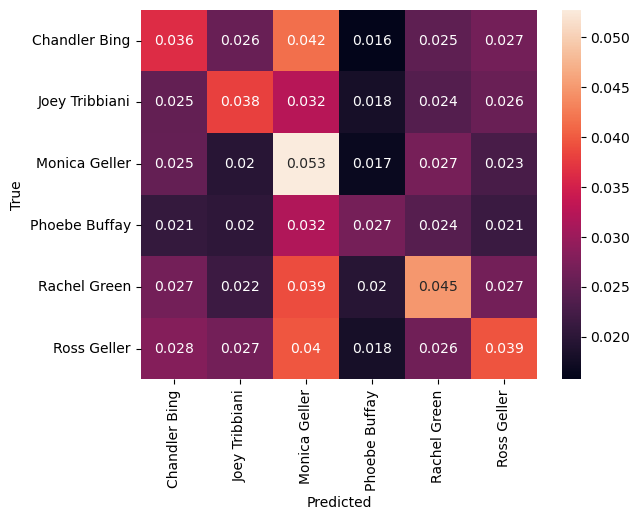

In [153]:
# E. Plot an appropriate visualization of the confusion matrix
sns.heatmap(df_confusion, annot=True)

In [154]:
# F. **/Discuss:/** Analyzing the confusion matrix, discuss:
#    - Which character is most distinct in the way they talk?
#    - Which two characters are the most similar in the way they talk?
#    - Which two characters are the least similar in the way they talk?

# - Monica is the most distinct in the way she talks
# - Monica and Chandler are the most similar in the way they talk (highest off-diagonal value)
# - Phoebe and Chandler are the least similar in the way they talk (lowest off-diagonal value)

---

**2.3 —** **/Discuss:/** Last, you discuss the results obtained in **2.2** with a friend, who asks you some thought-provoking questions.

A. Your friend proposes that you should create a measure of similarity between two characters in a given episode in a more direct way than what you've done in **2.2**.  Propose (but do not implement) said similarity metric.

B. Your friend also suggests that your analysis might not truly capture how two characters differ. According to her, if people are in the same conversation, they might speak similarly simply because they are in the same social context. Propose (but do not implement) a way of creating a dataset where this confounder does not exist.

C. Last, your friend complains about how you present your (normalized) confusion matrix. According to her, from reading the cells alone, it is unclear if the fraction of occurrences is higher or lower than what a random classifier would yield. Propose (but do not implement) a way of modifying the confusion matrix to address her concern.


In [ ]:
# A. Compute cosine similarity of the two vectors associated with each row of the TF-IDF matrix

# B. Create dataset where all 6 characters are present, to have the same social context

# C. Normalize it and substract the value of a random classifier

---